# This Notebook will serve for Data Cleaning of the Weather, Noise and Telraam datasets. The Telraam Dataset is also being retrieved in this notebook using API calls to the Telraam API. 

I think that we can create a noise predicting model, that uses the following features for a certain location and that needs to predict the noise level at that location in DBA:

1. Time,Day of the week, month of the year
2. Weather conditions: temperature, wind speed, wind direction, humidity, rain intensity, solar radiation
3. Traffic conditions: number of cars, number of trucks, number of buses, number of pedestrians, number of cyclists, number of motorbikes circulating in trough that location in a certain time period

We train it on the beginning of the naamsestraat and we test it on the end of the naamsestraat or we find noise data for another street in Leuven and we test it on that street.

## Weather Data [Final file: 'Weather_cleaned.csv']

#### Making the Necessary imports for the notebook

In [43]:
# imports for data profiling
import pandas as pd
import ydata_profiling
import sweetviz as sv
from autoviz import data_cleaning_suggestions
# imports for data visualization
import matplotlib.pyplot as plt
# imports for working with geospatial data
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
# imports for API requests
import requests

#### Loading in the Weather data

Explanation of abbreviations & units of measurements
Metadata.csv: 
- ID = Station's ID (ex. LC-XXX) [-]
- LAT = latitute (rounded to 3 decimals for privacy reasons) [-]
- LON = longitude (rounded to 3 decimals for privacy reasons) [-]
- ALT = altitude above sea level [m]
- LCZ = local climate zone [-]. For details: see accompanying publictation.
- LC = main landcover directly around weather station (0 = impervious/1= green) [-]
- building_height = mean building height in circular buffer 10m around weather station [m]
- SVF = mean sky view factor in circular buffer 10m around weather station [-]
- Installation_height = installation height of weather station [m]

LC_YYYYQX.csv: 
-	DATEUTC = Date and time (UTC) in POSIXct format: YYYY-MM-DD HH:MM:SS
-	ID = Station's ID (ex. LC-XXX) [-]
-	LC_HUMIDITY = Relative humidity [%]
-	LC_DWPTEMP = Dew point temperature [∞C]
-	LC_n = Number of 16 second observations in 10 minutes aggregate
-	LC_RAD = Solar radiation [W/m2]
-	LC_RAININ = Rain intensity [mm/h]
-	LC_DAILYRAIN = Daily rain sum [mm]
-	LC_WINDDIR = Wind direction [∞]
-	LC_WINDSPEED = Wind speed [m/s]
-	Date = Date in YYYY-MM-DD
-	Year = Year in YYYY
-	Month = Month in MM
-	Day = Day in DD
-	Hour = Hour in HH
-	Minute = Minute in MM
-	LC_RAD60 = Weighted radiation during last 60 minutes [W/m2]
-	LC_TEMP_QCL0 = Temperature at QCL0 [∞C]
-	LC_TEMP_QCL1 = Temperature at QCL1 [∞C]
-	LC_TEMP_QCL2 = Temperature at QCL2 [∞C]
-	LC_TEMP_QCL3 = Temperature at QCL3 [∞C]

In [2]:
# load csv and save as dataframe
df1 = pd.read_csv('data/weather_data/LC_2022Q1.csv')
df2 = pd.read_csv('data/weather_data/LC_2022Q2.csv')
df3 = pd.read_csv('data/weather_data/LC_2022Q3.csv')
df4 = pd.read_csv('data/weather_data/LC_2022Q4.csv')
# merge all dataframes
df = pd.concat([df1, df2, df3, df4], ignore_index=True)

# load metadata and save as dataframe
df_meta = pd.read_csv('data/weather_data/01_Metadata_v2.csv')

#### Data Profiling on the weather data

In [ ]:
# use pandas-profiling to generate a report on the df 
profile = df.profile_report(title='Pandas Profiling Report')
profile.to_file(output_file="EDA_weather_cleaned.html")

In [ ]:
# use autoviz to make suggestions on cleaning the data
data_cleaning_suggestions(df)

In [ ]:
# generate visualizations on the df using sweetviz
my_report = sv.analyze(df)
# save the report as an html file
my_report.show_html('EDA_weather_sweetviz.html')


#### Data Cleaning on the Weather data

In [6]:
# drop Year, Month, Day,Date, Hour,Minute columns from df because double info with DATEUTC
df.drop(['Year', 'Month', 'Day', 'Date', 'Hour', 'Minute'], axis=1, inplace=True)

In [7]:
# number of rows where LC_TEMP_QCL1 and LC_HUMIDITY  and LC_RAD60 are null
df[(df['LC_TEMP_QCL1'].isnull()) & (df['LC_HUMIDITY'].isnull()) & (df['LC_RAD60'].isnull())].shape

(277022, 15)

In [8]:
# data imputing not possible so we drop rows where LC_n is null see Next Markdown section
df.dropna(subset=['LC_n'], inplace=True)

In [9]:
df.shape

(5231981, 15)

In [10]:
# only keep the number part of the ID column and convert to int
df['ID'] = df['ID'].str[3:].astype(int)

Some columns are represented by floats but that is not necessary.

In [11]:
# convert LC_HUMIDITY column to int
df['LC_HUMIDITY'] = df['LC_HUMIDITY'].astype(int)
# convert LC_n column to int
df['LC_n'] = df['LC_n'].astype(int)
# convert LC_RAD column to int
df['LC_RAD'] = df['LC_RAD'].astype(int)

In [12]:
# according to the paper, QCL3 is the most accurate data so we drop QCL0, QCL1 and QCL2
df.drop(['LC_TEMP_QCL0', 'LC_TEMP_QCL1', 'LC_TEMP_QCL2'], axis=1, inplace=True)
# rename QCL3 to LC_TEMP
df.rename(columns={'LC_TEMP_QCL3': 'LC_TEMP'}, inplace=True)

In [13]:
# sort the df by ID and DATEUTC
df.sort_values(by=['ID', 'DATEUTC'], inplace=True)

### Handling Missing Values and Zeros

Tried data imputation to fill in missing values in LC_TEMP, but when LC_TEMP is missing, all the rest ==0, so not possible. We drop these as well

In [14]:
# show a random instance in df
df.sample(1)

,DATEUTC,ID,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP
5123328,2022-10-03 16:10:00,106,67,10.44,38,63,0.0,0.0,-146.0,0.22,126.0,16.13152


In [15]:
# show an instance where LC_TEMP is null
df[df['LC_TEMP'].isnull()].sample(1)

,DATEUTC,ID,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP
4813344,2022-11-28 00:10:00,74,99,7.35,38,0,0.0,0.0,0.0,0.0,0.0,NaN


In [16]:
# count the number of instances where LC_TEMP is null
print(df[df['LC_TEMP'].isnull()].shape)
# drop these rows
df.dropna(subset=['LC_TEMP'], inplace=True)

(30588, 12)


LC_WINDDIR equals 0 when LC_WINDSPEED equals 0, so it's not really a zero. It's just that the wind is not blowing. Should we replace these with NA ?

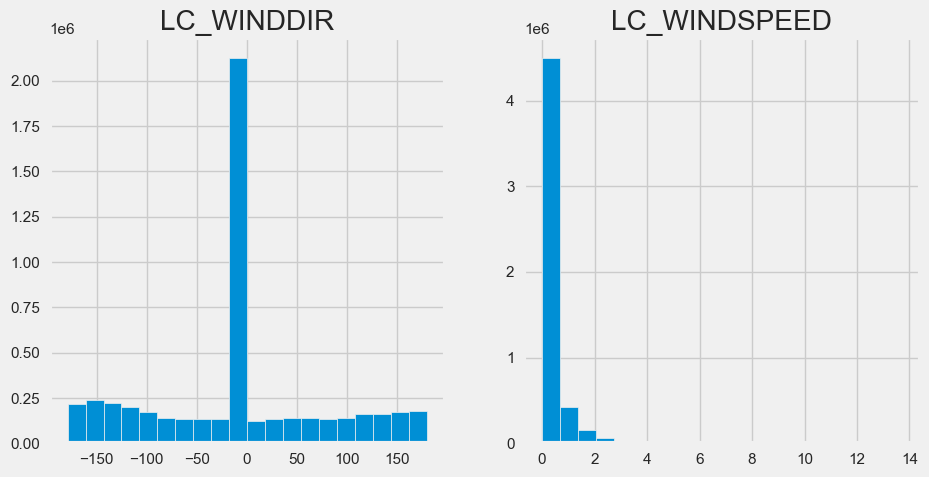

In [17]:
%matplotlib inline
# plot the distribution of LC_WINDDIR and LC_WINDSPEED using pyplot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(df['LC_WINDDIR'], bins=20)
plt.title('LC_WINDDIR')
plt.subplot(1, 2, 2)
plt.hist(df['LC_WINDSPEED'], bins=20)
plt.title('LC_WINDSPEED')
plt.show()

In [18]:
# is winddir 0 when windspeed is 0 ? YES !
df[df['LC_WINDSPEED'] == 0]['LC_WINDDIR'].value_counts()

 0.0      2002435
 90.0         575
-151.0        387
 155.0        379
 162.0        376
           ...   
-47.0         230
-17.0         227
-18.0         226
-36.0         225
-90.0          53
Name: LC_WINDDIR, Length: 360, dtype: int64

In [19]:
# is windspeed 0 when winddir is 0 ? YES !
df[df['LC_WINDDIR'] == 0]['LC_WINDSPEED'].value_counts()

0.00    2002435
0.01        496
0.02        394
0.03        277
0.04        249
         ...   
2.16          1
2.31          1
2.20          1
4.56          1
2.27          1
Name: LC_WINDSPEED, Length: 263, dtype: int64

Because the Wind direction is not important for our analysis, we will do not replace the 0 values of the wind direction with NA.

In [6]:
# save df as csv
df.to_csv('data/Weather_cleaned.csv', index=False)

In [3]:
# read the cleaned csv and save as dataframe
df = pd.read_csv('data/Weather_cleaned.csv')

In [ ]:
# create a new column year
df_weather['year'] = df_weather['DATEUTC'].str[:4]
# create a new column month
df_weather['month'] = df_weather['DATEUTC'].str[5:7]
# create a new column day_month
df_weather['day_month'] = df_weather['DATEUTC'].str[8:10]
# create a new column day_week
df_weather['day_week'] = pd.to_datetime(df_weather['DATEUTC']).dt.day_name()
# create a new column interval_start_time
df_weather['interval_start_time'] = df_weather['DATEUTC'].str[11:16] 

In [ ]:
# put the columns in the following order: ID, year, month, day_month, day_week, interval_start_time, LC_HUMIDITY	,LC_DWPTEMP	,LC_n	,LC_RAD	,LC_RAININ,	LC_DAILYRAIN	,LC_WINDDIR,	LC_WINDSPEED,	LC_RAD60,	LC_TEMP
df_weather = df_weather[['ID', 'year', 'month', 'day_month', 'day_week', 'interval_start_time', 'LC_HUMIDITY', 'LC_DWPTEMP', 'LC_n', 'LC_RAD', 'LC_RAININ', 'LC_DAILYRAIN', 'LC_WINDDIR', 'LC_WINDSPEED', 'LC_RAD60', 'LC_TEMP']]

In [ ]:
# save df as csv
df.to_csv('data/Weather_cleaned.csv', index=False)

## Telraam data [Final file: 'Telraam_VanDale.csv']

#### Trying to find a weather sensor that is close to Naamsestraat 80 (noise sensor)

We choose to work with the sensor at Naamsestraat 82 because it is the closest one to the Oude Markt and with complete data.

In [42]:
meta=pd.read_csv('data/weather_data/01_Metadata_v2.csv')

In [21]:
meta

,ID,LAT,LON,ALT,Local_climate_zone,Landcover,building_height,Sky_view_factor,installation_height
0,LC-002,50.847,4.756,47,9,1,4.280000,0.610367,2
1,LC-003,50.870,4.728,44,5,1,5.038286,0.691315,2
2,LC-004,50.871,4.685,31,9,1,9.050964,0.798586,2
3,LC-005,50.881,4.713,26,2,1,5.050000,0.685410,2
4,LC-006,50.912,4.716,13,6,1,0.000000,0.954032,2
...,...,...,...,...,...,...,...,...,...
112,LC-134,50.926,4.725,12,9,0,14.250000,0.692417,3
113,LC-135,50.874,4.760,92,14,1,0.000000,0.716678,2
114,LC-136,50.881,4.753,44,12,1,0.000000,0.825019,2
115,LC-137,50.854,4.694,42,6,1,2.757826,0.722500,2


In [44]:
# use geopy to find the ID of the closest weather station to the location with coordinates: 50.8771422, 4.7007241
geolocator = Nominatim(user_agent="my_user_agent")
location = geolocator.reverse("50.8750743, 4.6999583")
print(location.address)
print((location.latitude, location.longitude))
# find the distance between the location and the weather stations
distances = []
for i in range(meta.shape[0]):
    distances.append(geodesic((location.latitude, location.longitude), (meta['LAT'][i], meta['LON'][i])).km)
# add the distances to the meta dataframe
meta['distance'] = distances
# sort the dataframe by distance
meta.sort_values(by=['distance'], inplace=True)
meta.head()

Van Dalecollege, 80, Naamsestraat, Hertogensite, Leuven, Vlaams-Brabant, 3000, België / Belgique / Belgien
(50.87488945, 4.699574800427602)


,ID,LAT,LON,ALT,Local_climate_zone,Landcover,building_height,Sky_view_factor,installation_height,distance
96,LC-118,50.875,4.699,38,2,0,17.400000,0.712314,3,0.042286
91,LC-112,50.875,4.701,42,2,0,18.135126,0.635925,3,0.101065
88,LC-109,50.873,4.699,37,2,1,24.980000,0.389382,3,0.214052
95,LC-117,50.877,4.700,26,2,0,20.655555,0.651495,3,0.236690
92,LC-113,50.877,4.698,20,2,0,18.244532,0.653118,3,0.259639


Sensor LC-118 sits at 40 meters of Naamsestraat 80. We will use this sensor for our model.

In [45]:
location = geolocator.reverse("50.875, 4.699")
print(location.address)
print((location.latitude, location.longitude))

Pieter Van Dalepad, Hertogensite, Leuven, Vlaams-Brabant, 3000, België / Belgique / Belgien
(50.87497625263902, 4.698967232539431)


#### The closest Telraam sensor with the most reliable data to Naamsestraat 80 is the one at the Van DaleCollege with id: 347295. We will use this sensor for our model. We make the sequential calls to retrieve the data for that sensor over the total period of 2022.

In [19]:
df_clean = pd.DataFrame()

In [18]:
url = "https://telraam-api.net/v1/reports/traffic"

payload = "{\r\n  \"level\": \"segments\",\r\n  \"format\": \"per-hour\",\r\n  \"id\": \"347931\",\r\n  \"time_start\": \"2022-01-01 07:00:00Z\",\r\n  \"time_end\": \"2022-04-01 07:00:00Z\"\r\n}"
headers = {
  'X-Api-Key': 'v5gGtMOE5k2ltLBb17NkK9rab1JETS8J2wZ39lnw'
}

response = requests.request("POST", url, headers=headers, data=payload)

print(response.text)
# convert the response to a json object
json_response = response.json()
# convert the json object to a dataframe
df = pd.DataFrame(json_response['report'])

{"status_code": 200, "message": "ok", "report": [{"instance_id": -1, "segment_id": 347931, "date": "2022-01-01T07:00:00.000Z", "interval": "hourly", "uptime": 0.1430555556, "heavy": 0.0, "car": 6.9902912621, "bike": 0.0, "pedestrian": 0.0, "heavy_lft": 0.0, "heavy_rgt": 0.0, "car_lft": 6.9902912621, "car_rgt": 0.0, "bike_lft": 0.0, "bike_rgt": 0.0, "pedestrian_lft": 0.0, "pedestrian_rgt": 0.0, "direction": 1, "car_speed_hist_0to70plus": [0.0, 0.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0], "car_speed_hist_0to120plus": [0.0, 0.0, 0.0, 0.0, 0.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], "timezone": "Europe/Brussels", "v85": 26.5}, {"instance_id": -1, "segment_id": 347931, "date": "2022-01-01T08:00:00.000Z", "interval": "hourly", "uptime": 0.7925, "heavy": 1.261829653, "car": 1.261829653, "bike": 8.832807571, "pedestrian": 0.0, "heavy_lft": 1.261829653, "heavy_rgt": 0.0, "car_lft": 1.261829653, "car_rgt": 0.0, "bike_lft": 3.785488959, "bi

We only need a couple features 

In [20]:
df_new=df[['date', 'uptime', 'heavy', 'car', 'bike', 'pedestrian', 'car_speed_hist_0to70plus', 'timezone', 'v85']]

In [21]:
# add df_new to df_clean
df_clean = pd.concat([df_clean, df_new], ignore_index=True)

In [22]:
# save df_clean as csv
df_clean.to_csv('data/Telraam_347295.csv', index=False)

### Cleaning and preprocessing the Telraam data

In [ ]:
df=pd.read_csv('data/Telraam_347295.csv')

Splitting the timestamp into different columns. This way the model can understand patterns better.

In [ ]:
# create a new column year
df['year'] = pd.to_datetime(df['date']).dt.year
# create a new column month
df['month'] = pd.to_datetime(df['date']).dt.month
# create a new column day_month
df['day_month'] = pd.to_datetime(df['date']).dt.day
# create a new column day_week as strings
df['day_week'] = pd.to_datetime(df['date']).dt.day_name()
# create a new column hour
df['interval_start_hour'] = pd.to_datetime(df['date']).dt.hour

In [ ]:
# add column location named Van DaleCollege. This is the approximate location of the telraam sensor.
df['location'] = 'His & Hears'

In [ ]:
# drop unnecessary columns
df.drop(columns=['timezone','car_speed_hist_0to70plus','uptime','date'], inplace=True)

In [ ]:
# rename heavy to avg_trucks, car to avg_cars, bike to avg_bikes, pedestrian to avg_pedestrians
df.rename(columns={'heavy': 'avg_trucks', 'car': 'avg_cars', 'bike': 'avg_bikes', 'pedestrian': 'avg_pedestrians'}, inplace=True)
# reorder the columns: location, year, month, day_month, day_week, interval_start_hour, avg_trucks, avg_cars, avg_bikes, avg_pedestrians, v85
df = df[['location', 'year', 'month', 'day_month', 'day_week', 'interval_start_hour', 'avg_trucks', 'avg_cars', 'avg_bikes', 'avg_pedestrians', 'v85']]

In [ ]:
# save as Telraam_VanDale.csv
df.to_csv('data/Telraam_Calvariekapel.csv', index=False)

In [ ]:
df=pd.read_csv('data/Telraam_Calvariekapel.csv')

Because the Telraam data can only be retrieved per-hour, we will have to resample the data to 10 minutes. We repeat every hour column 6 times and divide the values by 6. This way we get the average value for every 10 minutes.

In [ ]:
# for each row, create 6 new rows with interval_start_hour = {interval_start_hour}:00, {interval_start_hour}:10, {interval_start_hour}:20, {interval_start_hour}:30, {interval_start_hour}:40, {interval_start_hour}:50
df = df.groupby(['location', 'year', 'month', 'day_month', 'day_week', 'interval_start_hour', 'v85']).apply(lambda x: x.reindex(np.repeat(x.index.values, 6))).reset_index(drop=True)
# divide the avg_trucks, avg_cars, avg_bikes, avg_pedestrians by 6
df[['avg_trucks', 'avg_cars', 'avg_bikes', 'avg_pedestrians']] = df[['avg_trucks', 'avg_cars', 'avg_bikes', 'avg_pedestrians']].div(6)

In [ ]:
# make the the time columns more understandable
df['interval_start_hour'] = df['interval_start_hour'].astype(str)
df['interval_start_hour'] = df['interval_start_hour'].str.zfill(2)
df['hours'] = df['interval_start_hour'].str[:2]
# create a minutes column with values 00, 10, 20, 30, 40, 50
df['minutes'] = ['00', '10', '20', '30', '40', '50'] * int(len(df)/6)
df['interval_start_hour'] = df['hours'] + ':' + df['minutes']

In [ ]:
# drop hours and minutes columns
df.drop(columns=['hours', 'minutes'], inplace=True)
# rename interval_start_hour to interval_start_time
df.rename(columns={'interval_start_hour': 'interval_start_time'}, inplace=True)

In [ ]:
# save as Telraam_Calvariekapel.csv
df.to_csv('data/Telraam_Calvariekapel', index=False)

## Noise Data and Model Input data creation [Final file: 'model_input.csv']

In [46]:
df_noise = pd.read_csv('data/final_noise_data.csv')
df_weather = pd.read_csv('data/final_weather_data.csv')
df_calvarie = pd.read_csv('data/Telraam_Calvariekapel.csv')
# df_weather only where ID = 117
df_weather = df_weather[df_weather['ID'] == 118]
# df_noise only where location = Naamsestraat 35
df_noise = df_noise[(df_noise['location'] == 'Calvariekapel')]

In [47]:
# sort by location,month and day_month
df_noise.sort_values(by=['location','month','day_month'], inplace=True)
# rename 10_min_interval_start_time to interval_start_time
df_noise.rename(columns={'10_min_interval_start_time': 'interval_start_time'}, inplace=True)
df_noise.head()

,location,year,month,day_month,day_week,interval_start_time,lceq_avg,lcpeak_avg
146865,Calvariekapel,2022,1,1,Saturday,00:00,59.998050,76.173350
146866,Calvariekapel,2022,1,1,Saturday,00:10,55.488933,70.593450
146867,Calvariekapel,2022,1,1,Saturday,00:20,57.271517,71.628300
146868,Calvariekapel,2022,1,1,Saturday,00:30,55.490633,69.417433
146869,Calvariekapel,2022,1,1,Saturday,00:40,53.985467,66.882400


In [48]:
# create model_input dataframe 
model_input = pd.DataFrame()
# add df_noise dataframe
model_input = pd.concat([model_input, df_noise], ignore_index=True)
# match year	month	day_month	day_week	interval_start_time	from df_weather to model_input
model_input = pd.merge(model_input, df_weather, how='left', on=['year', 'month', 'day_month', 'day_week', 'interval_start_time'])
# match location	year	month	day_month	day_week	interval_start_time from df_calvarie to model_input
model_input = pd.merge(model_input, df_calvarie, how='left', on=['location', 'year', 'month', 'day_month', 'day_week', 'interval_start_time'])

In [49]:
model_input.head()

,location,year,month,day_month,day_week,interval_start_time,lceq_avg,lcpeak_avg,ID,LC_HUMIDITY,...,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP,avg_trucks,avg_cars,avg_bikes,avg_pedestrians,v85
0,Calvariekapel,2022,1,1,Saturday,00:00,59.998050,76.173350,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Calvariekapel,2022,1,1,Saturday,00:10,55.488933,70.593450,118.0,91.0,...,0.0,174.0,0.11,0.0,13.14485,NaN,NaN,NaN,NaN,NaN
2,Calvariekapel,2022,1,1,Saturday,00:20,57.271517,71.628300,118.0,90.0,...,0.0,-13.0,0.20,0.0,13.14540,NaN,NaN,NaN,NaN,NaN
3,Calvariekapel,2022,1,1,Saturday,00:30,55.490633,69.417433,118.0,90.0,...,0.0,-31.0,0.16,0.0,13.16009,NaN,NaN,NaN,NaN,NaN
4,Calvariekapel,2022,1,1,Saturday,00:40,53.985467,66.882400,118.0,90.0,...,0.0,-56.0,0.08,0.0,13.14488,NaN,NaN,NaN,NaN,NaN


In [50]:
model_input.tail(10)

,location,year,month,day_month,day_week,interval_start_time,lceq_avg,lcpeak_avg,ID,LC_HUMIDITY,...,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP,avg_trucks,avg_cars,avg_bikes,avg_pedestrians,v85
52550,Calvariekapel,2022,12,31,Saturday,22:20,60.004300,72.453733,118.0,56.0,...,0.002,13.0,0.12,0.0,16.23343,NaN,NaN,NaN,NaN,NaN
52551,Calvariekapel,2022,12,31,Saturday,22:30,59.556890,72.373278,118.0,55.0,...,0.002,1.0,1.14,0.0,16.22006,NaN,NaN,NaN,NaN,NaN
52552,Calvariekapel,2022,12,31,Saturday,22:40,59.917683,72.099200,118.0,54.0,...,0.002,4.0,1.33,0.0,16.37063,NaN,NaN,NaN,NaN,NaN
52553,Calvariekapel,2022,12,31,Saturday,22:50,60.518450,72.975467,118.0,54.0,...,0.002,-5.0,1.20,0.0,16.48180,NaN,NaN,NaN,NaN,NaN
52554,Calvariekapel,2022,12,31,Saturday,23:00,62.404633,75.090050,118.0,53.0,...,0.002,9.0,0.90,0.0,16.62328,NaN,NaN,NaN,NaN,NaN
52555,Calvariekapel,2022,12,31,Saturday,23:10,61.670367,74.547833,118.0,53.0,...,0.000,-4.0,1.28,0.0,16.63219,NaN,NaN,NaN,NaN,NaN
52556,Calvariekapel,2022,12,31,Saturday,23:20,63.011750,76.693433,118.0,53.0,...,0.000,22.0,0.82,0.0,16.61295,NaN,NaN,NaN,NaN,NaN
52557,Calvariekapel,2022,12,31,Saturday,23:30,63.776983,77.483350,118.0,53.0,...,0.000,2.0,0.62,0.0,16.53810,NaN,NaN,NaN,NaN,NaN
52558,Calvariekapel,2022,12,31,Saturday,23:40,66.172950,80.316817,118.0,53.0,...,0.000,-9.0,1.08,0.0,16.39468,NaN,NaN,NaN,NaN,NaN
52559,Calvariekapel,2022,12,31,Saturday,23:50,63.261703,76.894290,118.0,53.0,...,0.000,18.0,1.14,0.0,16.26945,NaN,NaN,NaN,NaN,NaN


As we can see, the noise data gopes from January 1st to December 31st. 

In [ ]:
# save as model_input.csv
model_input.to_csv('data/model_input.csv', index=False)

In [ ]:
# add a column Telraam data with values 1 if there is data from Telraam, 0 if not
model_input['Telraam data'] = np.where(model_input['avg_trucks'].isnull(), 0, 1)
# add a column Weather data with values 1 if there is data from Weather, 0 if not
model_input['Weather data'] = np.where(model_input['LC_TEMP'].isnull(), 0, 1)
# encode day_week as 1,2,3,4,5,6,7
model_input['day_week'] = model_input['day_week'].replace(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], [1,2,3,4,5,6,7])
# drop year
model_input.drop(columns=['year'], inplace=True)
# drop ID
model_input.drop(columns=['ID'], inplace=True)

In [ ]:
# put lceq and lcpeakin the last column
cols_at_end = ['lceq_avg', 'lcpeak_avg']
model_input = model_input[[c for c in model_input if c not in cols_at_end] + [c for c in cols_at_end if c in model_input]]
# create columns hour and minute from interval_start_time
model_input['hour'] = model_input['interval_start_time'].str[:2]
model_input['minute'] = model_input['interval_start_time'].str[3:]
# drop interval_start_time
model_input.drop(columns=['interval_start_time'], inplace=True)

Handling the different Datatypes !

In [ ]:
# replace all NaN values with 0
model_input.fillna(0, inplace=True)

# convert LC_HUMIDITY, LC_n,LC_RAD,LC_WINDDIR,LC_RAD60 to int
model_input['LC_HUMIDITY'] = model_input['LC_HUMIDITY'].astype(int)
model_input['LC_n'] = model_input['LC_n'].astype(int)
model_input['LC_RAD'] = model_input['LC_RAD'].astype(int)
model_input['LC_WINDDIR'] = model_input['LC_WINDDIR'].astype(int)
model_input['LC_RAD60'] = model_input['LC_RAD60'].astype(int)
model_input['hour'] = model_input['hour'].astype(int)
model_input['minute'] = model_input['minute'].astype(int)
# convert location object to string
model_input['location'] = model_input['location'].astype(str)
# round up to 4 decimals the following columns: avg_trucks, avg_cars, avg_bikes, avg_pedestrians,lceq_avg, lcpeak_avg
model_input['avg_trucks'] = model_input['avg_trucks'].round(4)
model_input['avg_cars'] = model_input['avg_cars'].round(4)
model_input['avg_bikes'] = model_input['avg_bikes'].round(4)
model_input['avg_pedestrians'] = model_input['avg_pedestrians'].round(4)
model_input['lceq_avg'] = model_input['lceq_avg'].round(4)
model_input['lcpeak_avg'] = model_input['lcpeak_avg'].round(4)
# show datatypes
model_input.dtypes

In [ ]:
# save as model_input.csv
model_input.to_csv('data/model_input.csv', index=False)